### **Demonstration: Online Incremental Learning vs XGBoost**

This notebook demonstrates the comparative performance of **Online Incremental Learning** models and **Non-Incremental Learning** models like XGBoost in dynamic data scenarios. Using detailed visualizations and metrics, we analyze the strengths and limitations of each approach.

Key aspects of the demonstration include:
- **Concept Drift Recovery**: How quickly and efficiently models regain accuracy when the data distribution shifts.
- **Memory Usage**: Comparison of memory efficiency between online and retraining-based models.
- **Training Time**: Analysis of computational efficiency for real-time applications.
- **Accuracy Trends**: Tracking accuracy improvement as more data is processed.

This notebook uses the accompanying `.py` file to implement and analyze both learning paradigms. It serves as an interactive exploration of the practical benefits of online models in real-world, evolving data streams.

In [1]:
!git clone https://github.com/TurboML-Inc/colab-notebooks.git

Cloning into 'colab-notebooks'...
remote: Enumerating objects: 419, done.
remote: Counting objects: 100% (419/419), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 419 (delta 334), reused 363 (delta 285), pack-reused 0 (from 0)
Receiving objects: 100% (419/419), 15.12 MiB | 1.30 MiB/s, done.
Resolving deltas: 100% (334/334), done.


In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
!bash colab-notebooks/install_turboml.sh

In [ ]:
! pip install xgboost

In [2]:
## Replace this connection details by signing into turboml.com ##
import turboml as tb
tb.init(backend_url=BACKEND_URL, api_key=API_KEY)
#################################################################

In [3]:
import sys
import time
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from turboml import LocalModel
from turboml.common.models import InputSpec
from turboml.common.dataloader import Inputs, Labels, PandasDataset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import warnings

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('https://github.com/songqiaohu/THU-Concept-Drift-Datasets-v1.0/raw/refs/heads/main/Datasets_in_CADM+/LSudden_3.csv')
df.head(10)

,x1,x2,x3,x4,x5,label
0,-6.481079,-6.242985,-9.531891,-6.968090,0.907054,1
1,5.042903,10.506421,2.528749,4.815682,-2.993558,0
2,2.173806,5.376893,6.429978,8.943717,-3.312305,1
3,8.696228,-13.301626,6.950536,-3.641624,4.728401,2
4,-11.403451,1.739396,-9.612974,-5.025895,7.536184,0
5,-1.517938,3.653680,-9.531835,7.654967,-3.506054,0
6,3.783037,-2.664017,-5.322132,0.983280,-4.604893,2
7,-5.280508,-6.294126,-8.153463,2.830699,-3.972099,1
8,2.525642,1.649270,6.150019,-9.985133,3.025769,1
9,6.168740,-0.663412,9.400588,-0.037433,-6.965257,2


In [ ]:
COLS = [f'f{i}' for i in range(len(df.columns)-1)] + ['label']
df.columns = COLS # renaming the columns as 'f1, f2, ..., label
df['label'] = pd.factorize(df['label'])[0] # mapping the categorical labels from 0, 1, 2 and so on...
df.describe()

,f0,f1,f2,f3,f4,label
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.002237,0.009549,0.000516,-0.000290,-0.003329,1.090531
std,8.659195,8.656719,5.768471,5.775230,5.779969,0.792733
min,-14.999979,-14.999970,-9.999994,-10.000000,-9.999982,0.000000
25%,-7.496444,-7.484103,-4.982924,-5.001308,-5.013451,0.000000
50%,0.005781,0.015272,-0.000886,-0.003483,0.003715,1.000000
75%,7.504715,7.510526,4.991598,5.000339,4.997230,2.000000
max,14.999997,14.999936,9.999973,9.999987,9.999997,2.000000


In [ ]:
stream = df[COLS[:-1]].reset_index()
labels = df[COLS[-1]].astype(int).reset_index()
NUM_CLASSES = df[COLS[-1]].nunique()
print(len(stream))
stream.info()

1000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   index   1000000 non-null  int64  
 1   f0      1000000 non-null  float64
 2   f1      1000000 non-null  float64
 3   f2      1000000 non-null  float64
 4   f3      1000000 non-null  float64
 5   f4      1000000 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 45.8 MB


# **Data Division**

We split our data into multiple parts for our demonstration, set the `NUM_PARTS` variable to the number of parts you want the data to be divided into.

For our demonstration we will use these parts for `static`, `batch` and `online` processing and evaluation.

In [ ]:
NUM_PARTS = 10

# Split both the features (stream) and the labels dataframe into NUM_PARTS parts
data_parts = np.array_split(stream, NUM_PARTS)
label_parts = np.array_split(labels, NUM_PARTS)

# 'data_parts' and 'label_parts' are lists of pandas DataFrames
for i, (data_part, label_part) in enumerate(zip(data_parts, label_parts)):
    print(f"Part {i+1} - Features Rows: {len(data_part)}, Labels Rows: {len(label_part)}")

Part 1 - Features Rows: 100000, Labels Rows: 100000
Part 2 - Features Rows: 100000, Labels Rows: 100000
Part 3 - Features Rows: 100000, Labels Rows: 100000
Part 4 - Features Rows: 100000, Labels Rows: 100000
Part 5 - Features Rows: 100000, Labels Rows: 100000
Part 6 - Features Rows: 100000, Labels Rows: 100000
Part 7 - Features Rows: 100000, Labels Rows: 100000
Part 8 - Features Rows: 100000, Labels Rows: 100000
Part 9 - Features Rows: 100000, Labels Rows: 100000
Part 10 - Features Rows: 100000, Labels Rows: 100000


### **Windowed Metric Calculation Function**

This function is defined for calculating the accuracy, f1 score and the roc_auc score in a windowed manner, where the `window_size` and the `step_size` are passed into the parameters.

In [ ]:
# Function to calculate windowed metrics
def calculate_windowed_metric(predictions, labels, window_size, step_size=1, metric='accuracy'):
    metrics = []
    num_steps = (len(predictions) - window_size) // step_size + 1

    for i in tqdm(range(num_steps)):
        start = i * step_size
        end = start + window_size
        if end > len(predictions):
            break

        # Calculate the chosen metric
        if metric == 'accuracy':
            score = accuracy_score(labels[start:end], predictions[start:end])
        elif metric == 'f1':
            score = f1_score(labels[start:end], predictions[start:end], average='weighted')
        elif metric == 'roc_auc':
            try:
                score = roc_auc_score(labels[start:end], predictions[start:end])
            except ValueError:
                score = None  # In case of only one class present in this window
        else:
            raise ValueError("Unsupported metric. Choose 'accuracy', 'f1', or 'roc_auc'.")

        # Append score if valid
        if score is not None:
            metrics.append(score)

    return metrics


In [ ]:
# preparing the input specification for the Local Models
numerical_fields = ['f0', 'f1', 'f2', 'f3', 'f4']

input_spec = InputSpec(
    key_field='index',
    numerical_fields=numerical_fields,
    categorical_fields=[],
    textual_fields=[],
    imaginal_fields=[],
    time_field="",
    label_field='label'
    )

## **Online Model vs XGBoost**

We will show the performance and efficiency of one of our online models (HoeffdingTreeClassifier) trained in an online learning manner in comparison against the XGBoost trained in a continual learning manner.

You can feel free to change the BATCH_SIZE and the XGB_PARAMS.

In [ ]:
# Parameters
BATCH_SIZE = 10000
XGB_PARAMS = {
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric': 'mlogloss',
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

def benchmark_and_store_results(batch_size, xgb_params)
  # initial online model training
  input_data = Inputs(
      dataset_id="input_stream",
      dataframe=data_parts[0],
      key_field='index',
      numerical_fields=numerical_fields
  )

  label_data = Labels(
      dataset_id="input_labels",
      dataframe=label_parts[0],
      key_field='index',
      label_field='label'
  )

  online_model = tb.HoeffdingTreeClassifier(n_classes=NUM_CLASSES)
  online_model_local = online_model.to_local_model(input_spec)
  online_model_local.learn(input_data, label_data)

  # merging the newer data other than the one used for making the initial trained version of the online model
  merged_data = pd.concat([data_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)
  merged_labels = pd.concat([label_parts[i].reset_index() for i in range(1, 10)], ignore_index=True)

  BATCH_SIZE = batch_size
  XGB_PARAMS = xgb_params

  num_batches = len(merged_data) // BATCH_SIZE

  # Initialize variables
  non_incremental_accuracies = []
  incremental_accuracies = []
  data_points_processed = []

  incremental_predictions_all = []
  non_incremental_predictions_all = []
  gt_labels_all = []

  # Track training times and memory usage
  training_time_online = 0
  training_time_xgb = 0
  memory_usage_online = []
  memory_usage_xgb = []

  # Initialize tb model
  all_data = pd.DataFrame(columns=merged_data.columns)
  all_data = all_data.drop(columns=['index'], errors='ignore')
  all_labels = np.array([])

  # Start training with streaming data
  for start_idx in tqdm(range(0, len(merged_data), BATCH_SIZE)):
      # if start_idx % 5 == 0:
      #     print(f"{start_idx}/{len(merged_data)} processed...")
      end_idx = start_idx + BATCH_SIZE
      if end_idx > len(merged_data):
          break

      batch_data = merged_data.iloc[start_idx:end_idx]
      batch_labels = merged_labels.iloc[start_idx:end_idx].squeeze()

      # Incremental Learning with tb model
      input_data = Inputs(
          dataset_id="input_stream",
          dataframe=batch_data,
          key_field='index',
          numerical_fields=numerical_fields
      )
      label_data = Labels(
          dataset_id="input_labels",
          dataframe=batch_labels,
          key_field='index',
          label_field='label'
      )

      start_time_online = time.time()
      out = online_model_local.predict(input_data)
      incremental_accuracy = accuracy_score(batch_labels['label'].values, out['predicted_class'])
      training_time_online += time.time() - start_time_online
      incremental_accuracies.append(incremental_accuracy)

      incremental_predictions_all.extend(out['predicted_class'].tolist())
      gt_labels_all.extend(batch_labels['label'].values)
      online_model_local.learn(input_data, label_data)

      # Update full data
      batch_data = batch_data.drop(columns=['index'], errors='ignore')
      all_data = pd.concat([all_data, batch_data], ignore_index=True)
      all_labels = np.concatenate([all_labels, batch_labels['label'].astype(int).values])

      # Track memory usage
      memory_usage_online.append(sys.getsizeof(batch_data) + sys.getsizeof(batch_labels))
      memory_usage_xgb.append(sys.getsizeof(all_data) + sys.getsizeof(all_labels))

      # Non-Incremental Learning (XGBoost)
      all_data = all_data.drop(columns=['level_0'], errors='ignore')
      dtrain_full = xgb.DMatrix(all_data, label=all_labels, enable_categorical=True)
      start_time_xgb = time.time()
      xgb_model = xgb.train(XGB_PARAMS, dtrain_full, num_boost_round=100)
      training_time_xgb += time.time() - start_time_xgb

      batch_data = batch_data.drop(columns=['level_0'], errors='ignore')
      dtest = xgb.DMatrix(batch_data)
      non_incremental_predictions = xgb_model.predict(dtest).argmax(axis=1)
      non_incremental_accuracy = accuracy_score(batch_labels['label'].values, non_incremental_predictions)
      non_incremental_accuracies.append(non_incremental_accuracy)

      non_incremental_predictions_all.extend(non_incremental_predictions)
      data_points_processed.append(len(all_labels))

  # Save results for analysis
  with open('comparison_measures.pkl', 'wb') as f:
      pickle.dump({
          'incremental_accuracies': incremental_accuracies,
          'non_incremental_accuracies': non_incremental_accuracies,
          'data_points_processed': data_points_processed,
          'training_time_online': training_time_online,
          'training_time_xgb': training_time_xgb,
          'memory_usage_online': memory_usage_online,
          'memory_usage_xgb': memory_usage_xgb
      }, f)

  print("function run complete and results stored...")

benchmark_and_store_results(BATCH_SIZE, XGB_PARAMS)

100%|██████████| 90/90 [33:29<00:00, 22.33s/it]


In [4]:
# Load stored data
with open('comparison_measures.pkl', 'rb') as f:
    results = pickle.load(f)

### **Accuracy Trends: Online vs Non-Incremental Learning**

This experiment compares **Online Incremental Learning (TurboML)** and **Non-Incremental Learning (XGBoost)** in a streaming data setup. TurboML updates the model on-the-fly, showing faster accuracy recovery and better overall performance. XGBoost needs to retrain from scratch after each batch, leading to slower improvements. The plot below highlights the accuracy trends for both approaches as more data is processed.

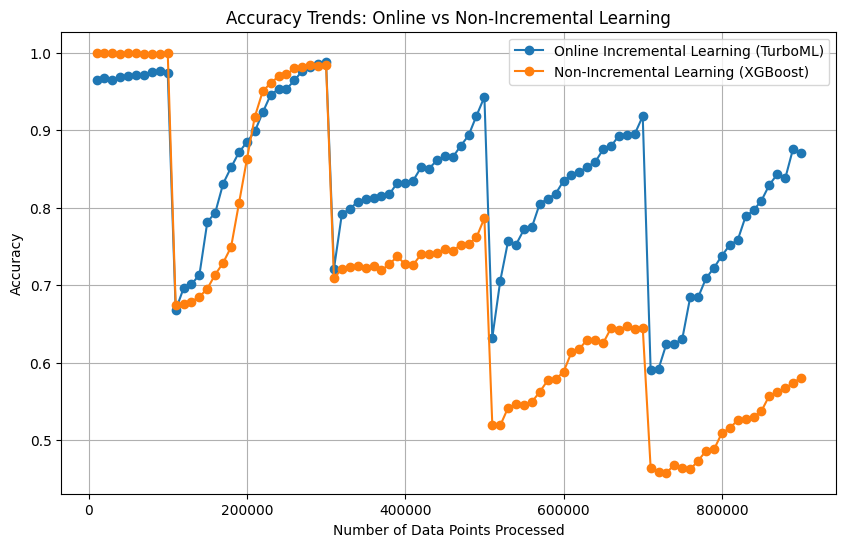

In [8]:
# 1. Accuracy Trends Over Time
incremental_acc = results['incremental_accuracies']
non_incremental_acc = results['non_incremental_accuracies']
data_points = results['data_points_processed']

plt.figure(figsize=(10, 6))
plt.plot(data_points, incremental_acc, marker='o', label='Online Incremental Learning (TurboML)')
plt.plot(data_points, non_incremental_acc, marker='o', label='Non-Incremental Learning (XGBoost)')

plt.title("Accuracy Trends: Online vs Non-Incremental Learning")
plt.xlabel("Number of Data Points Processed")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()


### **Recovery During Concept Drift: Online vs Non-Incremental Learning**

Concept drift occurs when the relationship between features and labels changes, causing a drop in model accuracy. Recovery measures how quickly models regain accuracy after drift.

#### Metrics:
1. **Accuracy Gain per Batch**: Average accuracy improvement per batch during recovery phases, calculated as total gain divided by the number of batches in each phase.
2. **Accuracy Gain per Unit Time**: Accuracy improvement relative to time taken, computed as total gain divided by recovery duration.

**TurboML** adapts faster by updating on-the-fly, achieving higher recovery rates per batch and time. **XGBoost** needs to retrain on all data, recovering more slowly. The plots below highlight these differences.

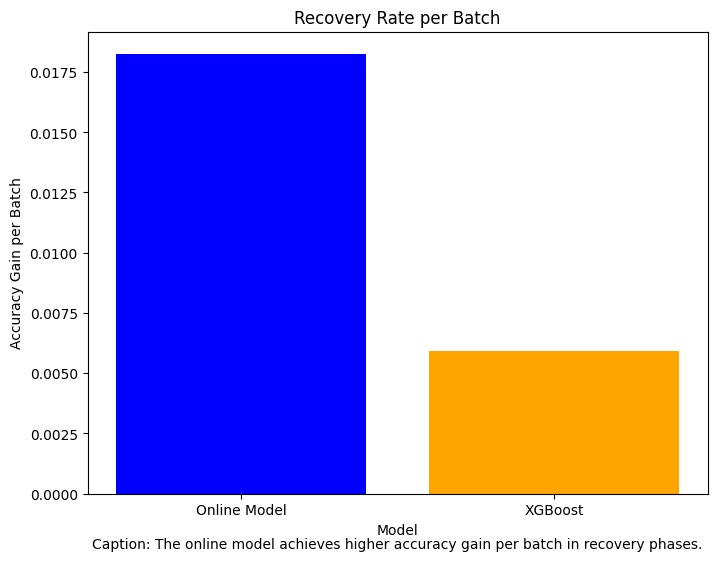

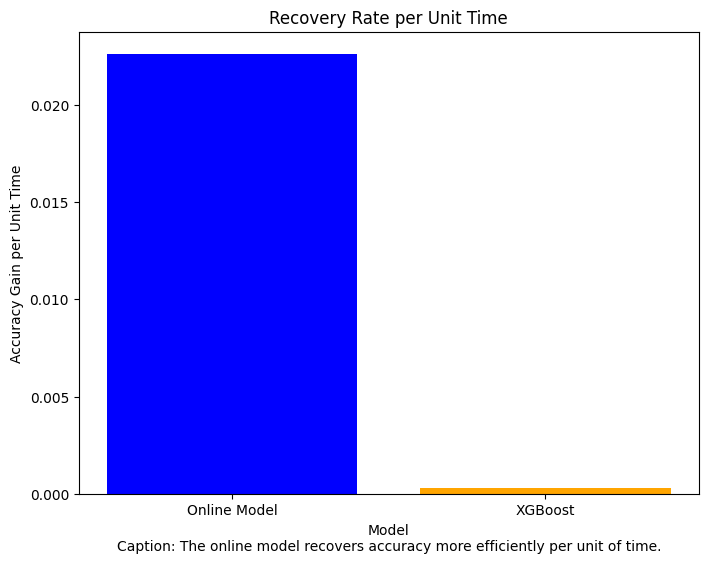

In [9]:
incremental_acc = np.array(results['incremental_accuracies'])
non_incremental_acc = np.array(results['non_incremental_accuracies'])
data_points = np.array(results['data_points_processed'])
time_online = results['training_time_online']
time_xgb = results['training_time_xgb']

def identify_recovery_phases(accuracies):
    recovery_phases = []
    in_recovery = False
    start_idx = 0
    for i in range(1, len(accuracies)):
        if accuracies[i] < accuracies[i - 1] and not in_recovery:
            in_recovery = True
            start_idx = i
        elif accuracies[i] >= accuracies[i - 1] and in_recovery:
            if i == len(accuracies) - 1 or accuracies[i + 1] < accuracies[i]:
                recovery_phases.append((start_idx, i))
                in_recovery = False
    return recovery_phases

def compute_accuracy_gain_per_batch(accuracies, recovery_phases):
    gains_per_batch = []
    for start, end in recovery_phases:
        total_gain = accuracies[end] - accuracies[start]
        num_batches = end - start
        if num_batches > 0:
            gains_per_batch.append(total_gain / num_batches)
    return np.mean(gains_per_batch) if gains_per_batch else 0

def compute_accuracy_gain_per_time(accuracies, recovery_phases, total_time):
    gains_per_time = []
    for start, end in recovery_phases:
        total_gain = accuracies[end] - accuracies[start]
        phase_time = (end - start) / len(accuracies) * total_time
        if phase_time > 0:
            gains_per_time.append(total_gain / phase_time)
    return np.mean(gains_per_time) if gains_per_time else 0

recovery_phases_online = identify_recovery_phases(incremental_acc)
recovery_phases_xgb = identify_recovery_phases(non_incremental_acc)

gain_per_batch_online = compute_accuracy_gain_per_batch(incremental_acc, recovery_phases_online)
gain_per_batch_xgb = compute_accuracy_gain_per_batch(non_incremental_acc, recovery_phases_xgb)

gain_per_time_online = compute_accuracy_gain_per_time(incremental_acc, recovery_phases_online, time_online)
gain_per_time_xgb = compute_accuracy_gain_per_time(non_incremental_acc, recovery_phases_xgb, time_xgb)

# 2. Recovery Rate per Batch
plt.figure(figsize=(8, 6))
plt.bar(["Online Model", "XGBoost"], [gain_per_batch_online, gain_per_batch_xgb], color=["blue", "orange"])
plt.title("Recovery Rate per Batch")
plt.xlabel("Model")
plt.ylabel("Accuracy Gain per Batch")
plt.text(0.5, min(gain_per_batch_online, gain_per_batch_xgb) - 0.1, "Caption: The online model achieves higher accuracy gain per batch in recovery phases.",
         ha='center', va='top', fontsize=10, transform=plt.gca().transAxes)
plt.show()

# 3. Recovery Rate per Unit Time
plt.figure(figsize=(8, 6))
plt.bar(["Online Model", "XGBoost"], [gain_per_time_online, gain_per_time_xgb], color=["blue", "orange"])
plt.title("Recovery Rate per Unit Time")
plt.xlabel("Model")
plt.ylabel("Accuracy Gain per Unit Time")
plt.text(0.5, min(gain_per_time_online, gain_per_time_xgb) - 0.1, "Caption: The online model recovers accuracy more efficiently per unit of time.",
         ha='center', va='top', fontsize=10, transform=plt.gca().transAxes)
plt.show()


### **Memory Usage Comparison: Online vs Non-Incremental Learning**

Efficient memory usage is crucial in real-time learning systems. This comparison evaluates the average memory consumed by **Online Incremental Learning (TurboML)** and **Non-Incremental Learning (XGBoost)** during training:

- **Online Model**: Processes batches incrementally, requiring significantly less memory as it does not need to store or reprocess all prior data.
- **XGBoost**: Retains and reprocesses all data for every batch, leading to much higher memory consumption.

The plot below illustrates that TurboML's memory efficiency makes it better suited for large-scale or resource-constrained scenarios.

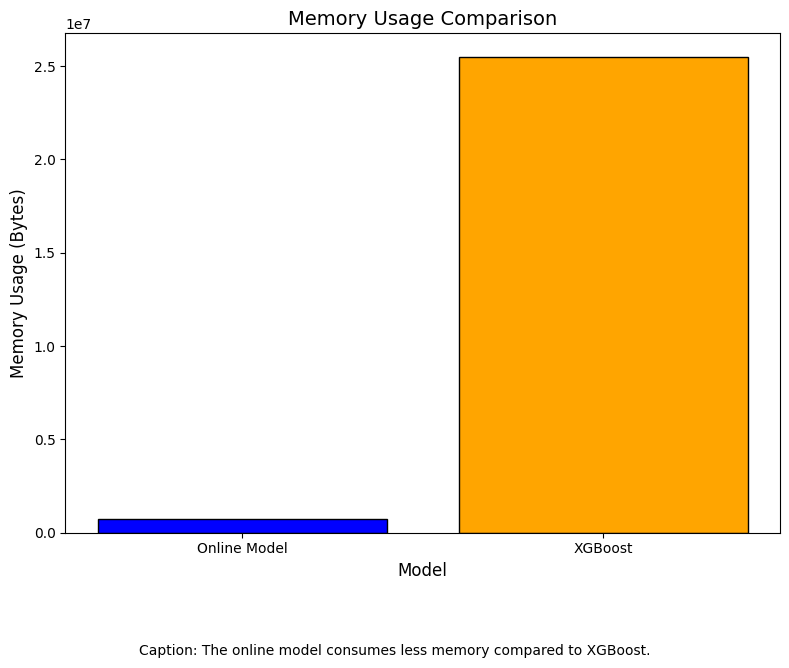

In [11]:
# 4. Memory Usage Comparison
memory_online = np.array(results['memory_usage_online'])
memory_xgb = np.array(results['memory_usage_xgb'])

avg_memory_online = np.mean(memory_online)
avg_memory_xgb = np.mean(memory_xgb)

models = ["Online Model", "XGBoost"]
memory_usage = [avg_memory_online, avg_memory_xgb]

plt.figure(figsize=(8, 6))
plt.bar(models, memory_usage, color=["blue", "orange"], edgecolor='black')

plt.xlabel("Model", fontsize=12)
plt.ylabel("Memory Usage (Bytes)", fontsize=12)
plt.title("Memory Usage Comparison", fontsize=14)

plt.figtext(0.5, -0.1, "Caption: The online model consumes less memory compared to XGBoost.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()


### Training Time Comparison: Online vs Non-Incremental Learning

Training time is a critical factor in real-time applications. This comparison evaluates the time taken by **Online Incremental Learning (TurboML)** and **Non-Incremental Learning (XGBoost)**:

- **Online Model**: Updates incrementally with each batch, resulting in significantly faster training times.
- **XGBoost**: Needs to retrain on all accumulated data for every batch, leading to much higher computational overhead and longer training times.

The plot below clearly shows that TurboML's efficiency in training makes it ideal for time-sensitive applications.

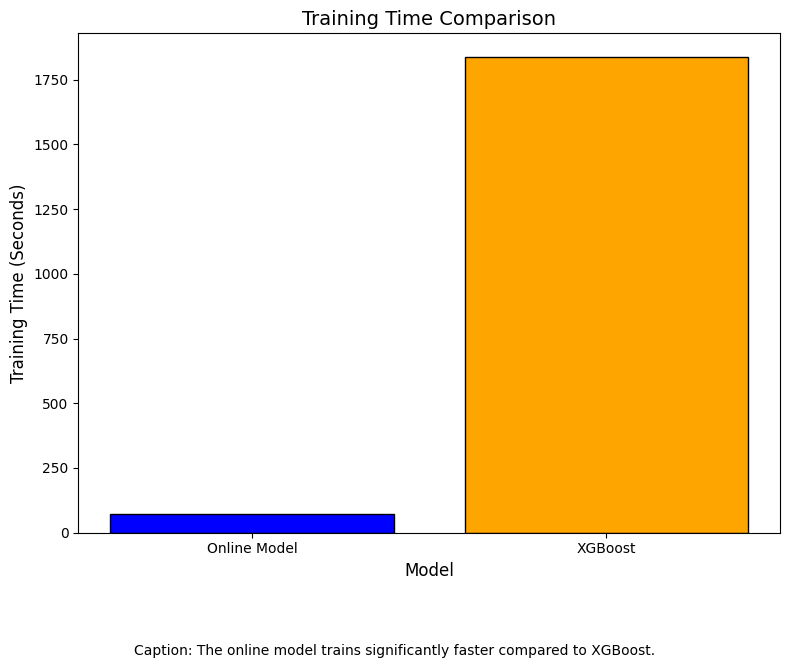

In [12]:
# 5. Training Time Comparison
time_online = results['training_time_online']
time_xgb = results['training_time_xgb']

models = ["Online Model", "XGBoost"]
training_times = [time_online, time_xgb]

plt.figure(figsize=(8, 6))
plt.bar(models, training_times, color=["blue", "orange"], edgecolor='black')

plt.xlabel("Model", fontsize=12)
plt.ylabel("Training Time (Seconds)", fontsize=12)
plt.title("Training Time Comparison", fontsize=14)

plt.figtext(0.5, -0.1, "Caption: The online model trains significantly faster compared to XGBoost.",
            wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()
